# Multiple Subject Processing

In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import mne
from mne_bids import (BIDSPath,read_raw_bids)
import sys
sys.path.insert(0,'.')
import os
import gc
from tqdm.notebook import tqdm


import ccs_eeg_utils
import config
from tools import get_valid_input
from visualization import plot_erp
from s00_add_reference import add_reference_channel
from s01_downsample_filter import down_sampling, band_filter, notch_filter
from s02_drop_bad_channels import drop_bad_channels, reref
from s03_07_trial_rejection import trial_rejection_cust
from s04_ICA import get_ica, get_iclabel, iccomponent_removal_author
from s05_interpolation import interpolation
from s06_early_trial_removal import exclude_early_trials
from s07_epoching import epoching, epoching_cust
from s09_make_erps import get_evoked, get_evoked_difference, compute_grand_average
from s10_rewp_calculation import rewp_calculation

In [31]:
SUBJECTS = list(config.SUBJECT_INFO.keys())

USER = get_valid_input(
    'Select the user (options: qian/zheng): ',
    list(config.BIDS_ROOT.keys())
)

Input accepted:qian


In [32]:
### Dictionary for epoching conditions
epoch_dict = config.CONDITIONS_DICT['feedback_locked']

### Subject info list
subject_info = config.SUBJECT_INFO

In [33]:
mne.set_log_level('WARNING') # to avoid too many info messages

# Authors' pipeline

In [38]:
ACTIVE_PIPELINE = 'original'
group_evokeds_ori = {}

for subject_id in tqdm(SUBJECTS, desc='Processing subjects', leave=True):
    # ------ LOAD DATA ------
    cfg = config.PIPELINES[ACTIVE_PIPELINE]
    root = config.BIDS_ROOT[USER]

    bids_path = BIDSPath(subject=subject_id, task='casinos',
                        datatype='eeg', suffix='eeg',
                        root=root)
    # read the file
    raw = read_raw_bids(bids_path)
    raw.load_data() 
    # fix the annotations readin
    ccs_eeg_utils.read_annotations_core(bids_path,raw)

    # montage setup
    montage_site2_path = os.path.join(root, 'code', config.LOCS_FILENAME['site2']) 
    montage_site2 = mne.channels.read_custom_montage(montage_site2_path)
    montage_common_path = os.path.join(root, 'code', config.LOCS_FILENAME['common'])
    montage_common = mne.channels.read_custom_montage(montage_common_path)


    # ------- PREPROCESSING PIPELINE -------
    # Add reference channel Fz
    raw = add_reference_channel(raw, 'Fz') 

    # Set custom montage
    raw.set_montage(montage_site2, match_case=False)

    # Downsample to 250 Hz
    eeg_down = down_sampling(raw, verbose=False)

    # Bandpass filter 0.1-30 Hz
    eeg_band = band_filter(eeg_down)

    # Notch filter at 50 Hz and harmonics
    eeg_band_notch = notch_filter(eeg_band)

    # Drop bad channels and reference channel
    eeg_ica = drop_bad_channels(subject_info[subject_id]['bad_channels'], eeg_band_notch)
    eeg_ica = reref(eeg_ica)

    ## get the dictionary for the events
    evts, evts_dict = mne.events_from_annotations(eeg_ica)
    evts_dict_stim = {k: evts_dict[k] for k in evts_dict.keys() if k in config.CONDITIONS_DICT['onset_locked']}

    # Trial rejection using customized function
    rejection_params = config.PIPELINES['original']['rejection_params']['ica']
    trials, rejection_info = trial_rejection_cust(eeg_ica, evts, evts_dict_stim, **rejection_params)
    
    # ICA and ICLabel
    ica = get_ica(trials, config.PIPELINES['original']['ica_method'])
    ic_labels = get_iclabel(trials, ica, method='iclabel')
    eeg_band_notch = iccomponent_removal_author(eeg_band_notch, ica)

    # Interpolation of bad channels
    eeg_band_notch = interpolation(eeg_band_notch, verbose=False)

    # exclude early trials
    eeg_final = exclude_early_trials(eeg_band_notch, config.PIPELINES[ACTIVE_PIPELINE]['early_trial_deletion'], verbose=False)

    # Epoching
    rejection_params = config.PIPELINES['original']['rejection_params']['erp']
    bad_channel_criteria = config.PIPELINES['original']['bad_channels_rejection_criteria']
    epochs_all, rejection_info = epoching_cust(epoch_dict, eeg_final, **rejection_params)
    
    # Get evoked responses
    all_evokeds = get_evoked(epoch_dict, epochs_all, proportiontocut=config.PIPELINES[ACTIVE_PIPELINE]['evoked_proportiontocut'])

    group_evokeds_ori[subject_id] = all_evokeds

    del raw
    gc.collect()

Processing subjects:   0%|          | 0/12 [00:00<?, ?it/s]

/var/folders/t4/tpd64s9d2xb_cdt_fwtwlr480000gn/T/ipykernel_53752/4210376743.py:13: RuntimeWarning: Unable to map the following column(s) to to MNE:
participant: 27
date: 18-Mar-2022 13:55:40
handedness: R
order: 50-50 mixed 80-20
stimuli: a lemon an orange
  raw = read_raw_bids(bids_path)


Average Reference: Keeping both.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Using data from preloaded Raw for 410 events and 751 original time points ...
Selecting by non-zero PCA components: 31 components
Computing Extended Infomax ICA
Using data from preloaded Raw for 410 events and 751 original time points ...
Fitting ICA took 20.5s.


/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/s04_ICA.py:35: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  # so it's better to combine the result of autolabel and munual check in our case
/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/s04_ICA.py:85: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  }
/var/folders/t4/tpd64s9d2xb_cdt_fwtwlr480000gn/T/ipykernel_53752/4210376743.py:13: RuntimeWarning: Unable to map the following column(s) to to MNE:
participant: 28
date: 21-Mar-2022 14:57:27
h

Average Reference: Keeping both.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Using data from preloaded Raw for 362 events and 751 original time points ...
Selecting by non-zero PCA components: 31 components
Computing Extended Infomax ICA
Using data from preloaded Raw for 362 events and 751 original time points ...
Fitting ICA took 18.5s.


/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/s04_ICA.py:35: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  # so it's better to combine the result of autolabel and munual check in our case
/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/s04_ICA.py:85: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  }
/var/folders/t4/tpd64s9d2xb_cdt_fwtwlr480000gn/T/ipykernel_53752/4210376743.py:13: RuntimeWarning: Unable to map the following column(s) to to MNE:
participant: 29
date: 31-Mar-2022 15:03:22
h

Average Reference: Keeping both.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Using data from preloaded Raw for 415 events and 751 original time points ...
Selecting by non-zero PCA components: 31 components
Computing Extended Infomax ICA
Using data from preloaded Raw for 415 events and 751 original time points ...
Fitting ICA took 23.9s.


/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/s04_ICA.py:35: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  # so it's better to combine the result of autolabel and munual check in our case
/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/s04_ICA.py:85: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  }
/var/folders/t4/tpd64s9d2xb_cdt_fwtwlr480000gn/T/ipykernel_53752/4210376743.py:13: RuntimeWarning: Unable to map the following column(s) to to MNE:
participant: 30
date: 04-Apr-2022 15:47:01
h

Average Reference: Keeping both.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Using data from preloaded Raw for 360 events and 751 original time points ...
Selecting by non-zero PCA components: 31 components
Computing Extended Infomax ICA
Using data from preloaded Raw for 360 events and 751 original time points ...
Fitting ICA took 19.2s.


/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/s04_ICA.py:35: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  # so it's better to combine the result of autolabel and munual check in our case
/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/s04_ICA.py:85: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  }
/var/folders/t4/tpd64s9d2xb_cdt_fwtwlr480000gn/T/ipykernel_53752/4210376743.py:13: RuntimeWarning: Unable to map the following column(s) to to MNE:
participant: 31
date: 06-Apr-2022 11:00:58
h

Average Reference: Keeping both.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Using data from preloaded Raw for 418 events and 751 original time points ...
Selecting by non-zero PCA components: 31 components
Computing Extended Infomax ICA
Using data from preloaded Raw for 418 events and 751 original time points ...
Fitting ICA took 23.0s.


/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/s04_ICA.py:35: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  # so it's better to combine the result of autolabel and munual check in our case
/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/s04_ICA.py:85: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  }
/var/folders/t4/tpd64s9d2xb_cdt_fwtwlr480000gn/T/ipykernel_53752/4210376743.py:13: RuntimeWarning: Unable to map the following column(s) to to MNE:
participant: 32
date: 07-Apr-2022 13:33:53
h

Average Reference: Keeping both.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Using data from preloaded Raw for 383 events and 751 original time points ...
Selecting by non-zero PCA components: 31 components
Computing Extended Infomax ICA
Using data from preloaded Raw for 383 events and 751 original time points ...
Fitting ICA took 19.8s.


/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/s04_ICA.py:35: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  # so it's better to combine the result of autolabel and munual check in our case
/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/s04_ICA.py:85: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  }
/var/folders/t4/tpd64s9d2xb_cdt_fwtwlr480000gn/T/ipykernel_53752/4210376743.py:13: RuntimeWarning: Unable to map the following column(s) to to MNE:
participant: 33
date: 08-Apr-2022 13:10:38
h

Average Reference: Keeping both.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Using data from preloaded Raw for 427 events and 751 original time points ...
Selecting by non-zero PCA components: 31 components
Computing Extended Infomax ICA
Using data from preloaded Raw for 427 events and 751 original time points ...
Fitting ICA took 22.8s.


/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/s04_ICA.py:35: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  # so it's better to combine the result of autolabel and munual check in our case
/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/s04_ICA.py:85: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  }
/var/folders/t4/tpd64s9d2xb_cdt_fwtwlr480000gn/T/ipykernel_53752/4210376743.py:13: RuntimeWarning: Unable to map the following column(s) to to MNE:
participant: 34
date: 08-Apr-2022 15:52:25
h

Average Reference: Keeping both.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Using data from preloaded Raw for 429 events and 751 original time points ...
Selecting by non-zero PCA components: 31 components
Computing Extended Infomax ICA
Using data from preloaded Raw for 429 events and 751 original time points ...
Fitting ICA took 22.5s.


/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/s04_ICA.py:35: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  # so it's better to combine the result of autolabel and munual check in our case
/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/s04_ICA.py:85: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  }
/var/folders/t4/tpd64s9d2xb_cdt_fwtwlr480000gn/T/ipykernel_53752/4210376743.py:13: RuntimeWarning: Unable to map the following column(s) to to MNE:
participant: 35
date: 13-Apr-2022 10:04:33
h

Average Reference: Keeping both.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Using data from preloaded Raw for 330 events and 751 original time points ...
Selecting by non-zero PCA components: 31 components
Computing Extended Infomax ICA
Using data from preloaded Raw for 330 events and 751 original time points ...
Fitting ICA took 19.4s.


/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/s04_ICA.py:35: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  # so it's better to combine the result of autolabel and munual check in our case
/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/s04_ICA.py:85: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  }
/var/folders/t4/tpd64s9d2xb_cdt_fwtwlr480000gn/T/ipykernel_53752/4210376743.py:13: RuntimeWarning: Unable to map the following column(s) to to MNE:
participant: 36
date: 13-Apr-2022 12:21:42
h

Average Reference: Keeping both.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Using data from preloaded Raw for 422 events and 751 original time points ...
Selecting by non-zero PCA components: 31 components
Computing Extended Infomax ICA
Using data from preloaded Raw for 422 events and 751 original time points ...
Fitting ICA took 23.2s.


/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/s04_ICA.py:35: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  # so it's better to combine the result of autolabel and munual check in our case
/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/s04_ICA.py:85: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  }
/var/folders/t4/tpd64s9d2xb_cdt_fwtwlr480000gn/T/ipykernel_53752/4210376743.py:13: RuntimeWarning: Unable to map the following column(s) to to MNE:
participant: 37
date: 25-Apr-2022 14:07:29
h

Average Reference: Keeping both.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Using data from preloaded Raw for 425 events and 751 original time points ...
Selecting by non-zero PCA components: 31 components
Computing Extended Infomax ICA
Using data from preloaded Raw for 425 events and 751 original time points ...
Fitting ICA took 23.5s.


/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/s04_ICA.py:35: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  # so it's better to combine the result of autolabel and munual check in our case
/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/s04_ICA.py:85: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  }
/var/folders/t4/tpd64s9d2xb_cdt_fwtwlr480000gn/T/ipykernel_53752/4210376743.py:13: RuntimeWarning: Unable to map the following column(s) to to MNE:
participant: 38
date: 27-Apr-2022 14:06:19
h

Average Reference: Keeping both.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Using data from preloaded Raw for 431 events and 751 original time points ...
Selecting by non-zero PCA components: 31 components
Computing Extended Infomax ICA
Using data from preloaded Raw for 431 events and 751 original time points ...
Fitting ICA took 23.4s.


/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/s04_ICA.py:35: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  # so it's better to combine the result of autolabel and munual check in our case
/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/s04_ICA.py:85: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  }


In [42]:
grand_averages_ori = compute_grand_average(epoch_dict, group_evokeds_ori)

## Plotting

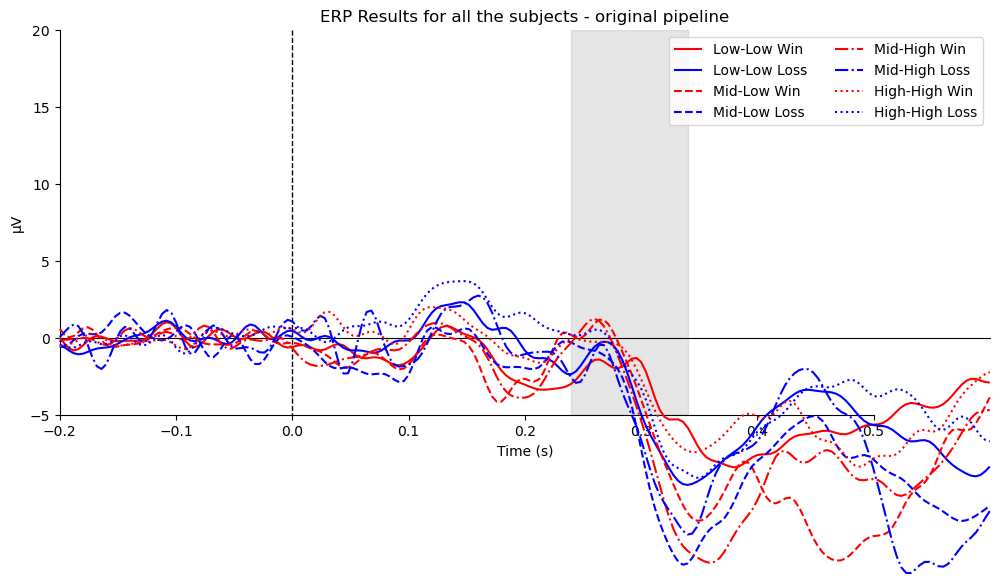

In [43]:
plot_erp(all_evokeds, ylim=[-5, 20], diff=False, title=f"ERP Results for all the subjects - {ACTIVE_PIPELINE} pipeline");

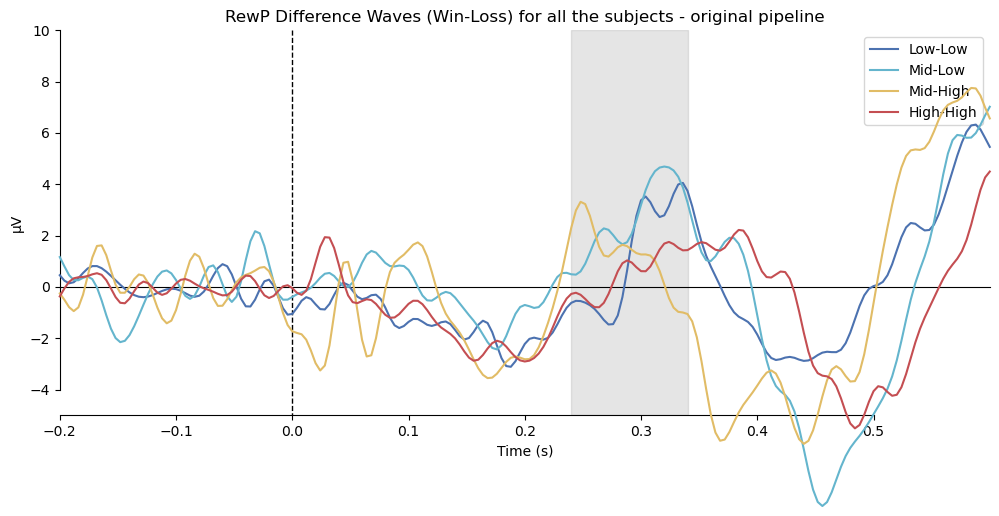

In [44]:
diff_evokeds = get_evoked_difference(all_evokeds)
plot_erp(diff_evokeds, diff=True, title=f"RewP Difference Waves (Win-Loss) for all the subjects - {ACTIVE_PIPELINE} pipeline");

Plotting Topomap for: Low-Low


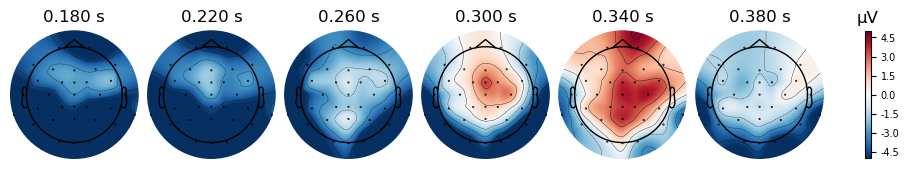

Plotting Topomap for: Mid-Low


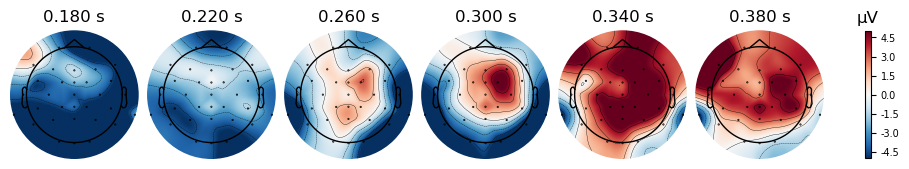

Plotting Topomap for: Mid-High


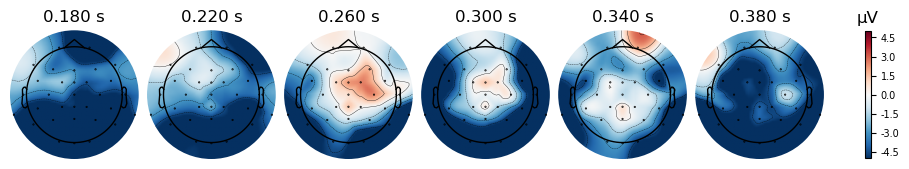

Plotting Topomap for: High-High


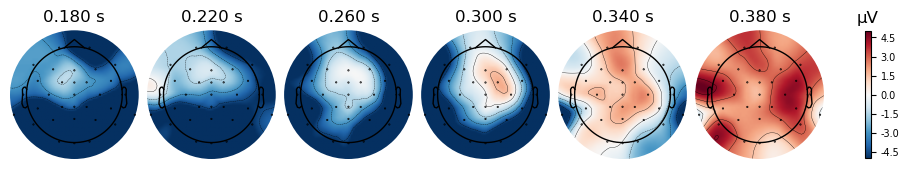

In [45]:
times = [0.18, 0.22, 0.26, 0.30, 0.34, 0.38] # Fewer time points to save space
vlimit = (-5, 5)

for condition, evoked in diff_evokeds.items():
    print(f"Plotting Topomap for: {condition}")
    evoked.plot_topomap(times=times, ch_type='eeg', colorbar=True, vlim=vlimit)

## (TBC) ours pipeline

In [ ]:
ACTIVE_PIPELINE = 'proposed'
group_evokeds_prop = {}

for subject_id in tqdm(SUBJECTS, desc='Processing subjects', leave=True):
    # ------ LOAD DATA ------
    cfg = config.PIPELINES[ACTIVE_PIPELINE]
    root = config.BIDS_ROOT[USER]

    bids_path = BIDSPath(subject=subject_id, task='casinos',
                        datatype='eeg', suffix='eeg',
                        root=root)
    # read the file
    raw = read_raw_bids(bids_path)
    raw.load_data() 
    # fix the annotations readin
    ccs_eeg_utils.read_annotations_core(bids_path,raw)

    # montage setup
    montage_site2_path = os.path.join(root, 'code', config.LOCS_FILENAME['site2']) 
    montage_site2 = mne.channels.read_custom_montage(montage_site2_path)
    montage_common_path = os.path.join(root, 'code', config.LOCS_FILENAME['common'])
    montage_common = mne.channels.read_custom_montage(montage_common_path)


    # ------- PREPROCESSING PIPELINE -------
    # Add reference channel Fz
    raw = add_reference_channel(raw, 'Fz') 

    # Set custom montage
    raw.set_montage(montage_site2, match_case=False)

    # Downsample to 250 Hz
    eeg_down = down_sampling(raw, verbose=False)

    # Bandpass filter 0.1-30 Hz
    eeg_band = band_filter(eeg_down)

    # Notch filter at 50 Hz and harmonics
    eeg_band_notch = notch_filter(eeg_band)

    # Drop bad channels and reference channel
    eeg_ica = drop_bad_channels(subject_info[subject_id]['bad_channels'], eeg_band_notch)
    eeg_ica = reref(eeg_ica)

    ## get the dictionary for the events
    evts, evts_dict = mne.events_from_annotations(eeg_ica)
    evts_dict_stim = {k: evts_dict[k] for k in evts_dict.keys() if k in config.CONDITIONS_DICT['onset_locked']}

    # Trial rejection using customized function
    rejection_params = config.PIPELINES['original']['rejection_params']['ica']
    trials, rejection_info = trial_rejection_cust(eeg_ica, evts, evts_dict_stim, **rejection_params)
    
    # ICA and ICLabel
    ica = get_ica(trials, config.PIPELINES['original']['ica_method'])
    ic_labels = get_iclabel(trials, ica, method='iclabel')
    eeg_band_notch = iccomponent_removal_author(eeg_band_notch, ica)

    # Interpolation of bad channels
    eeg_band_notch = interpolation(eeg_band_notch, verbose=False)

    # exclude early trials
    eeg_final = exclude_early_trials(eeg_band_notch, config.PIPELINES[ACTIVE_PIPELINE]['early_trial_deletion'], verbose=False)

    # Epoching
    rejection_params = config.PIPELINES['original']['rejection_params']['erp']
    bad_channel_criteria = config.PIPELINES['original']['bad_channels_rejection_criteria']
    epochs_all, rejection_info = epoching(epoch_dict, eeg_final, **rejection_params)
    
    # Get evoked responses
    all_evokeds = get_evoked(epoch_dict, epochs_all, proportiontocut=config.PIPELINES[ACTIVE_PIPELINE]['evoked_proportiontocut'])

    group_evokeds_ori[subject_id] = all_evokeds

    del raw
    gc.collect()

In [18]:
# calculate the grand average across subjects
grand_averages = {}
for condition in epoch_dict.keys():
    evokeds_list = [group_evokeds[subject_id][condition] for subject_id in group_evokeds.keys()]
    grand_averages[condition] = mne.grand_average(evokeds_list)
# # Save grand averages
# output_dir = os.path.join(bids_root, 'derivatives', 'grand_averages')
# os.makedirs(output_dir, exist_ok=True)
# for condition, evoked in grand_averages.items():
#     evoked.save(os.path.join(output_dir, f'grand_average_{condition.replace(" ", "_")}-ave.fif'))

## Plotting

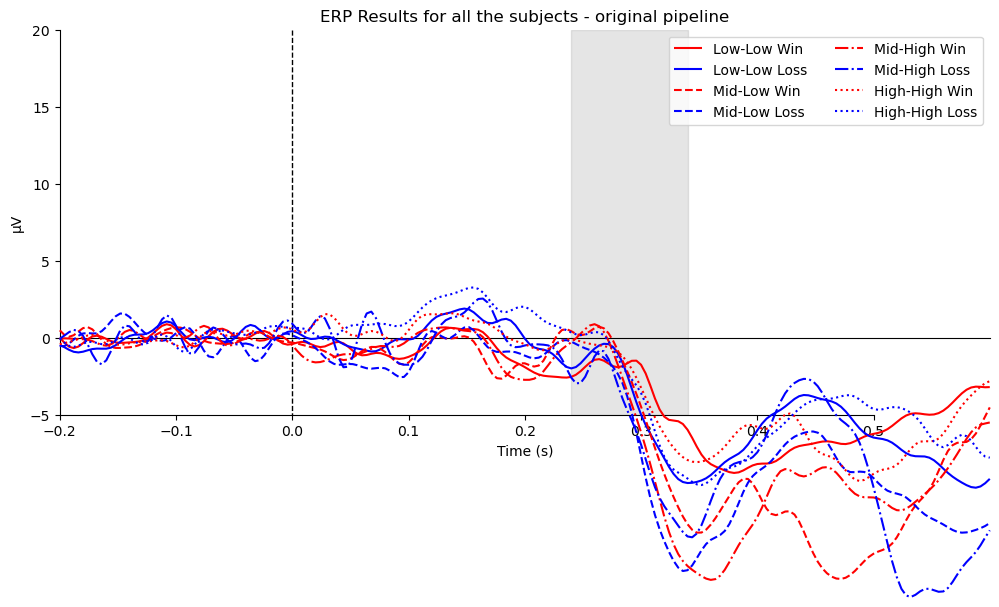

In [26]:
plot_erp(all_evokeds, ylim=[-5, 20], diff=False, title=f"ERP Results for all the subjects - {ACTIVE_PIPELINE} pipeline");

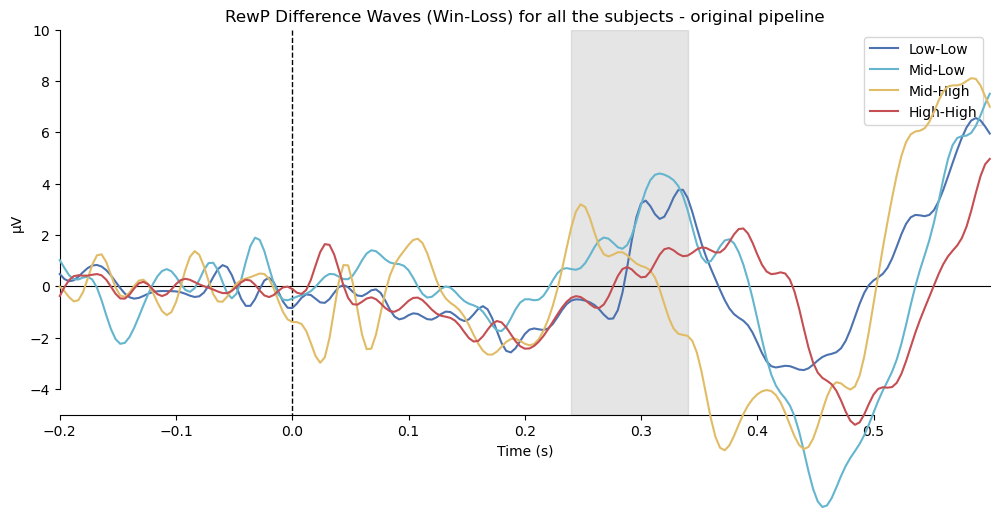

In [28]:
diff_evokeds = get_evoked_difference(all_evokeds)
plot_erp(diff_evokeds, diff=True, title=f"RewP Difference Waves (Win-Loss) for all the subjects - {ACTIVE_PIPELINE} pipeline");

In [ ]:
times = [0.18, 0.22, 0.26, 0.30, 0.34, 0.38] # Fewer time points to save space
vlimit = (-5, 5)

for condition, evoked in diff_evokeds.items():
    print(f"Plotting Topomap for: {condition}")
    evoked.plot_topomap(times=times, ch_type='eeg', colorbar=True, vlim=vlimit)